# Topic modelling on train travel comments dataset

## 1. Set up environment and load dataset

In [3]:
import json
import warnings
from typing import List, Any
from functools import wraps
from time import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cbook
import gensim
import tqdm
import nltk
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.utils import simple_preprocess, ClippedCorpus
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import Phrases, CoherenceModel
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
plt.style.use("ggplot") 
warnings.filterwarnings(action="ignore", category=matplotlib.cbook.mplDeprecation)
warnings.simplefilter(action='ignore', category=FutureWarning)

%reload_ext autoreload
%autoreload 2

[nltk_data] Downloading package wordnet to /home/miro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
reviews_file = open("../data/train_reviews.json")
reviews_dict = json.load(reviews_file)

## 2. Basic dataset preprocessing

 - Convert dictionary object into pandas dataframe, normalize `date` column, create `period` column representing **year-month**, **company** column extracted from url and expand `stars` column.

In [5]:
reviews = pd.DataFrame(reviews_dict)
reviews.head()

,date,title,text,url,stars
0,2015-10-10T14:32:51.000+00:00,Bad customer service. Staff are very impolite ...,Used national rail twice and on both occasions...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
1,2015-09-22T17:04:56.000+00:00,Pretty awful service,I phoned National rail to find out why several...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
2,2015-03-13T23:37:05.000+00:00,Awful staff,I travel from Brokenhast to southampton centra...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
3,2015-01-13T12:26:52.000+00:00,Very good,Saved about £50 on a single trip using Nationa...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-4 star-rating--medium
4,2011-05-28T15:00:36.000+00:00,Check it out.,I always use the national rail enquiry site wh...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-4 star-rating--medium


In [6]:
reviews["date"] = pd.to_datetime(reviews['date'])
reviews["period"] = reviews.date.dt.strftime('%Y-%m')
reviews["year"] = reviews.date.dt.year
reviews["company"] = reviews.url.str.replace("https://uk.trustpilot.com/review/www.", "", regex=False).str.split(".", expand=True)[0]

expanded_stars = reviews["stars"].str.split(expand=True).rename(columns={0: 'rating_type', 1: 'rating_id', 2: 'rating_level'})
reviews[expanded_stars.columns] = expanded_stars
reviews = reviews.drop(columns=["stars", "url"])

- Check if all ratings are of the same type and level.

In [7]:
print(f"""The unique rating types and levels are as follows:
{reviews.rating_type.unique().tolist()}, {reviews.rating_level.unique().tolist()}""")

The unique rating types and levels are as follows:
['star-rating'], ['star-rating--medium']


- Drop irrelevant `rating_type`and `rating_level` columns and convert `rating_id` into numeric column.

In [8]:
reviews = reviews.drop(columns={'rating_type', 'rating_level'}, errors='ignore')
if reviews.rating_id.dtype != 'int64':
    reviews['rating_id'] = reviews['rating_id'].str.strip("star-rating").astype(int)
reviews = reviews.reindex(columns=["date", "period", "year", "company", "title", "text", "rating_id"])
reviews.head()

,date,period,year,company,title,text,rating_id
0,2015-10-10 14:32:51+00:00,2015-10,2015,nationalrail,Bad customer service. Staff are very impolite ...,Used national rail twice and on both occasions...,1
1,2015-09-22 17:04:56+00:00,2015-09,2015,nationalrail,Pretty awful service,I phoned National rail to find out why several...,1
2,2015-03-13 23:37:05+00:00,2015-03,2015,nationalrail,Awful staff,I travel from Brokenhast to southampton centra...,1
3,2015-01-13 12:26:52+00:00,2015-01,2015,nationalrail,Very good,Saved about £50 on a single trip using Nationa...,4
4,2011-05-28 15:00:36+00:00,2011-05,2011,nationalrail,Check it out.,I always use the national rail enquiry site wh...,4


## 3. Exploratory data analysis

- Since the number of observations in year 2011 is only 2, we will delete that year so that only contiguous period of years 2015-2018 remained.

In [9]:
print(reviews.year.value_counts().tail(1))
reviews = reviews[reviews.year != 2011].reset_index(drop=True)

2011    2
Name: year, dtype: int64


- **Eliminate 580 duplicated reviews** in order not to train model on redundant information.

In [10]:
reviews = reviews.drop_duplicates().reset_index(drop=True)
reviews.shape

(1439, 7)

- Check the ratings distribution over years. We can see the **trend of increased dissatisfaction with the railway service** (on condition that `rating=1` is the worst rating grade). Also, we can see that reviews have been submitted primarily for six companies. **We also see that the overall number of reviews with positive rating (`rating_id` > 3) is rather small (~150). We will therefore exclude them from the development sample to be in line with the assignment (to find out suggestions for service improvements).**

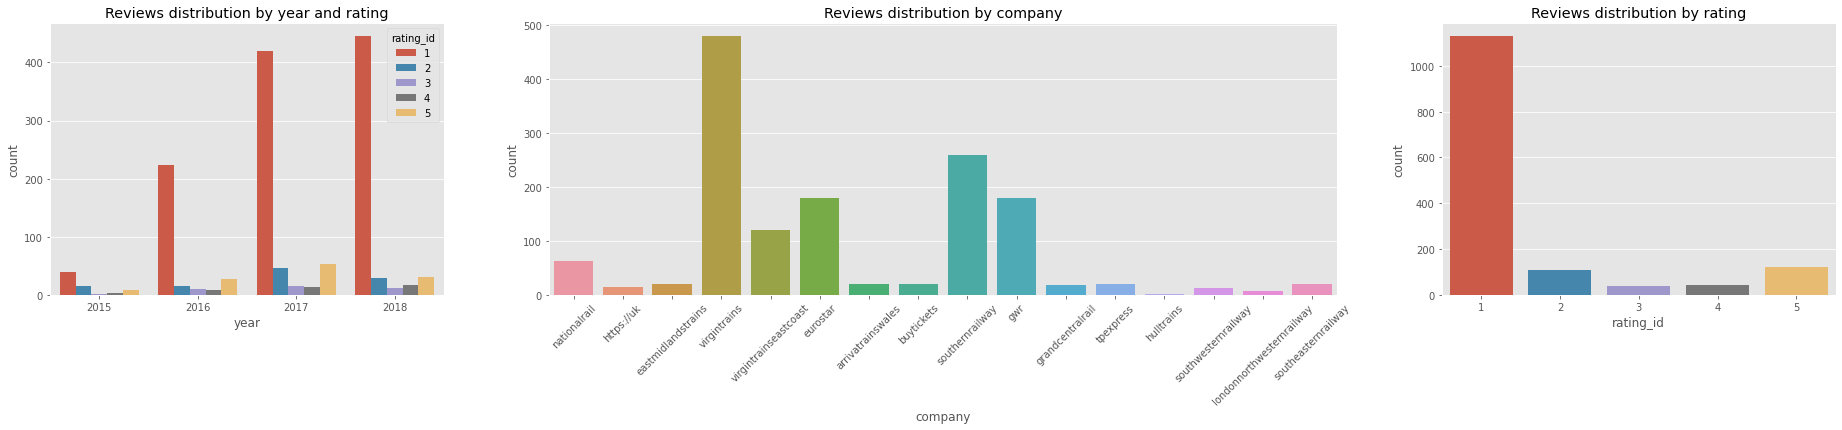

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(32, 5),  gridspec_kw={'width_ratios': [1, 2, 1]})
sns.countplot(x="year", hue="rating_id", data=reviews, ax=axs[0])
axs[0].set_title("Reviews distribution by year and rating")

sns.countplot(x="company", data=reviews, ax=axs[1])
axs[1].set_title("Reviews distribution by company")
axs[1].tick_params(axis="x", rotation=45);

sns.countplot(x="rating_id", data=reviews, ax=axs[2])
axs[2].set_title("Reviews distribution by rating");

- After exclusion of positive reviews:

(1275, 7)


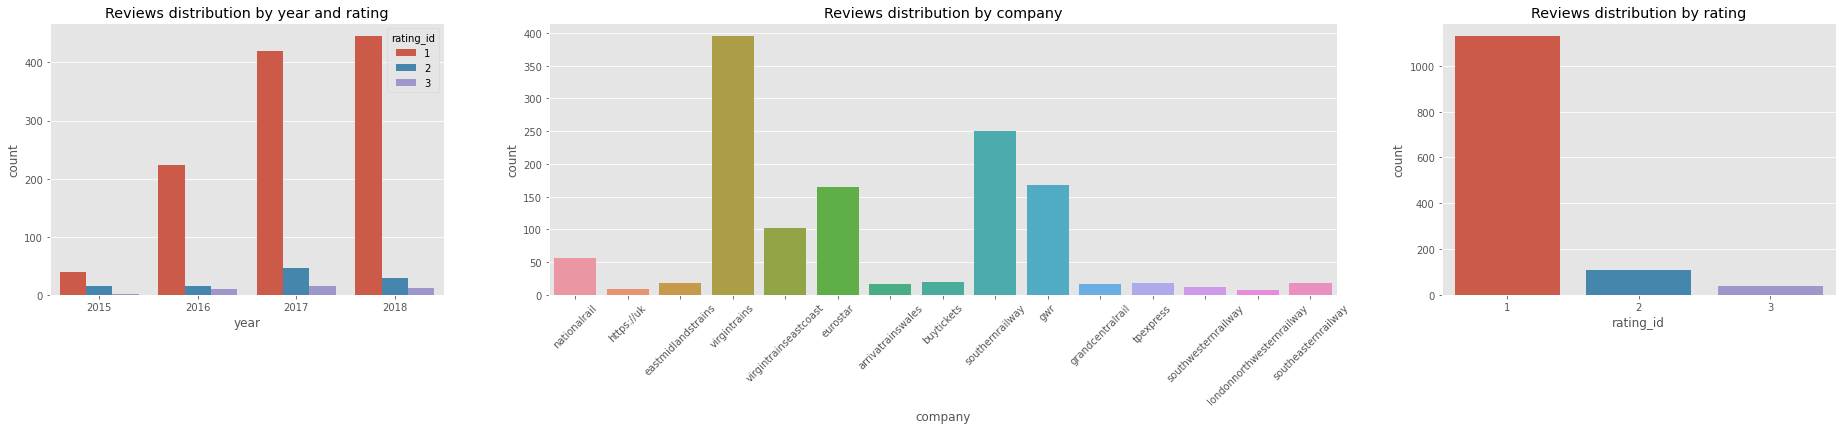

In [12]:
reviews = reviews[reviews.rating_id < 4].reset_index(drop=True)
print(reviews.shape)

fig, axs = plt.subplots(1, 3, figsize=(32, 5),  gridspec_kw={'width_ratios': [1, 2, 1]})
sns.countplot(x="year", hue="rating_id", data=reviews, ax=axs[0])
axs[0].set_title("Reviews distribution by year and rating")

sns.countplot(x="company", data=reviews, ax=axs[1])
axs[1].set_title("Reviews distribution by company")
axs[1].tick_params(axis="x", rotation=45);

sns.countplot(x="rating_id", data=reviews, ax=axs[2])
axs[2].set_title("Reviews distribution by rating");

- Distribution of reviews by month shows that the **number of reviews increased in first two years, then culminated at around 500 reviews per year.**

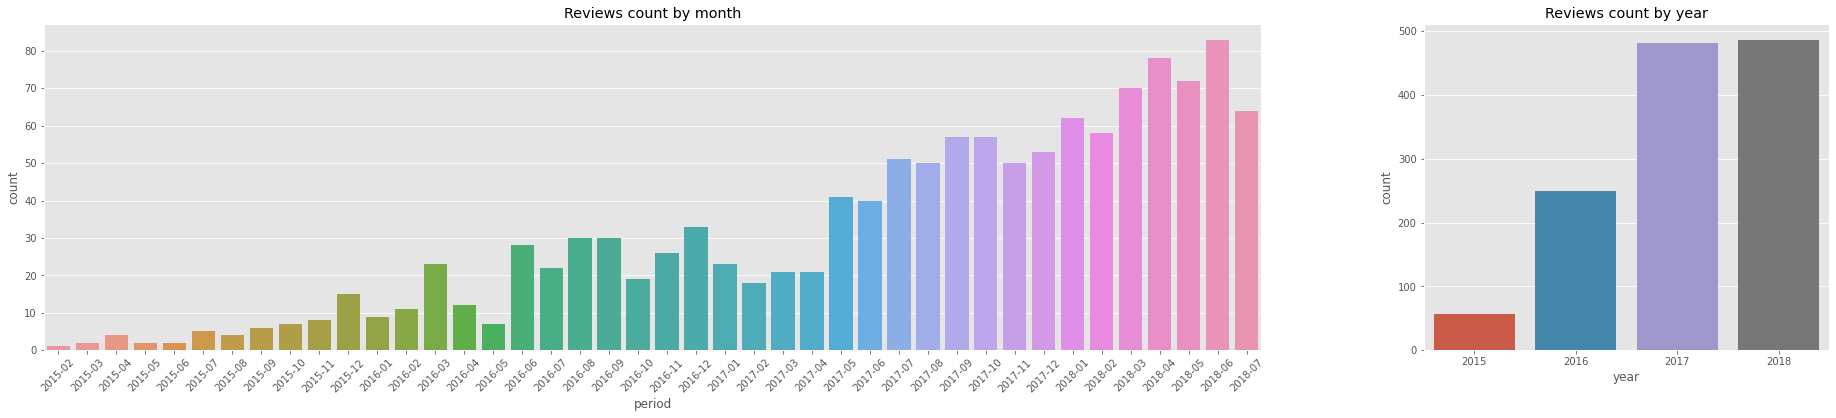

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(32, 6), gridspec_kw={'width_ratios': [3, 1]})
sns.countplot(x="period", data=reviews, order=reviews.period.value_counts().index.sort_values(), ax=axs[0])
axs[0].set_title("Reviews count by month")
axs[0].tick_params(axis="x", rotation=45)
sns.countplot(x="year", data=reviews, ax=axs[1])
axs[1].set_title("Reviews count by year");

- Check the distribution of review title lengths to find out whether, by chance, reviewers did not enter the review into title. At the same time, check the distribution of review text lengths. The means and standard deviations are displayed in figure titles. **Figures show that the reviews are actually restricted to text field and the title can be effectively ignored.**

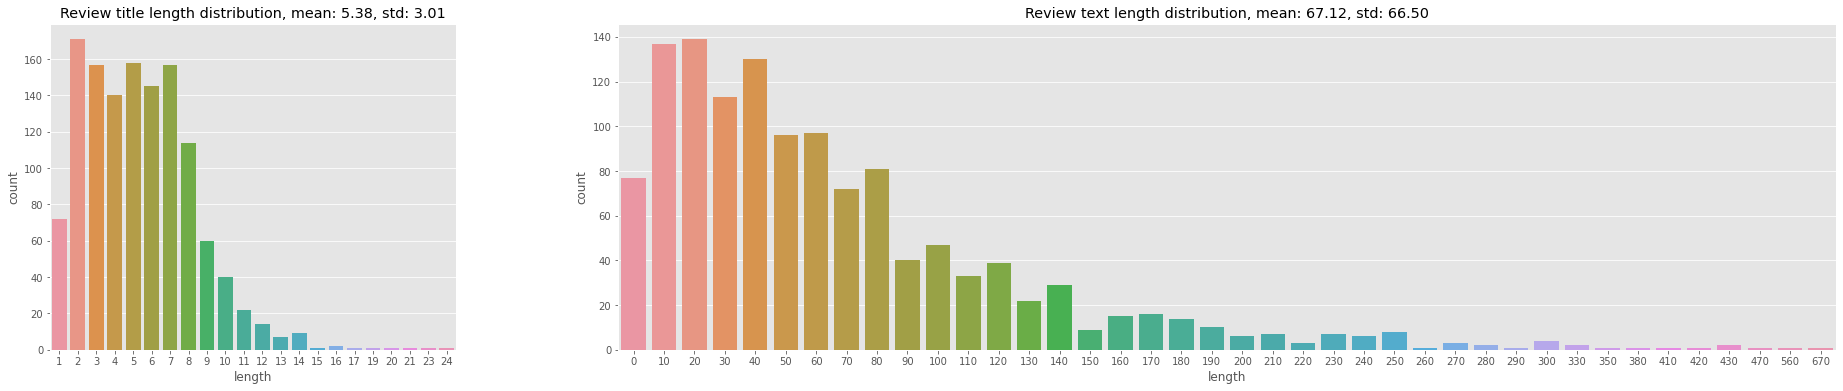

In [14]:
titles_list = [title for title in reviews.title.str.split()]
titles_lengths = pd.DataFrame(data={"length": [len(title) for title in titles_list]})

texts_list = [text for text in reviews.text.str.split()]
texts_lengths = pd.DataFrame(data={"length": [len(text) for text in texts_list]}).round(-1)

fig, axs = plt.subplots(1, 2, figsize=(32, 6), gridspec_kw={'width_ratios': [1, 3]})
sns.countplot(x="length", data=titles_lengths, ax=axs[0])
axs[0].set_title(f"Review title length distribution, mean: {titles_lengths.mean().values[0]:,.2f}, std: {titles_lengths.std().values[0]:,.2f}")
sns.countplot(x="length", data=texts_lengths, ax=axs[1])
axs[1].set_title(f"Review text length distribution, mean: {texts_lengths.mean().values[0]:,.2f}, std: {texts_lengths.std().values[0]:,.2f}");

## 4. Reviews text preprocessing

- Define helper functions.

In [15]:
def tokenize(docs: pd.Series, min_len: int = 2, max_len: int = 30) -> List[List[str]]:
    return [simple_preprocess(doc, deacc=True, min_len=min_len, max_len=max_len) for doc in docs]
        
def lemmatize(tokenized_docs: List[List[str]], lemmatizer: Any) -> List[List[str]]:
    res = [[lemmatizer.lemmatize(lemmatizer.lemmatize(token, pos='v'), pos='n')
            for token in doc] for doc in tokenized_docs]
    return res

def add_trigram_phrases(lemmatized_docs: List[List[str]], min_count: int, threshold: int) -> List[List[str]]:
    bigram_model = Phrases(lemmatized_docs, min_count=min_count, threshold=threshold)
    trigram_model = Phrases(bigram_model[lemmatized_docs], min_count=min_count, threshold=threshold)
    res = list(trigram_model[bigram_model[lemmatized_docs]])
    return res
     
def filter_stopwords(phrased_docs: List[List[str]]) -> List[List[str]]:
    return [[token for token in doc if token not in STOPWORDS] for doc in phrased_docs]   
    
def filter_short_tokens(filtered_stopwords_docs: List[List[str]], min_len: int = 3) -> List[List[str]]:
    return [[token for token in doc if len(token) >= min_len] for doc in filtered_stopwords_docs]

- Apply consecutive tokenization, deaccentation, **WordNet** lemmatization, trigrams addition, stopwords filtering and short token filtering to each review text to produce processed documents, i.e. list of lists of tokens. We decided not to use stemmer, because we wanted to keep actual words in the dictionary instead of trimmed ones in order to easily interpret the predicted topics.

In [16]:
lemmatizer = WordNetLemmatizer()
docs = reviews.text

tokenized_docs = tokenize(docs, min_len=2, max_len=20)
lemmatized_docs = lemmatize(tokenized_docs, lemmatizer)
phrased_docs = add_trigram_phrases(lemmatized_docs, min_count=2, threshold=10)
filtered_stopwords_docs = filter_stopwords(phrased_docs)
processed_docs = filter_short_tokens(filtered_stopwords_docs, min_len=3)

## 5. Gensim LDA model

- Define helper function.

In [17]:
def calc_coherence_metric(corpus, dictionary, topics, processed_docs, alpha, eta):
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=topics,
                                       passes=10,
                                       alpha=alpha,
                                       eta=eta,
                                       minimum_probability=0.1,
                                       random_state=10)
    
    coherence_model = CoherenceModel(model=lda_model,
                                     texts=processed_docs,
                                     corpus=corpus,
                                     coherence='c_v')
    
    return coherence_model.get_coherence()

- Plug tokenized documents into **gensim Dictionary** object and apply **filter_extremes function** filtering tokens that occur in less than 5 or in above 10% of documents. Then calculate **bag-of-words corpus** from the tokenized documents using the dictionary.

In [18]:
dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=5, no_above=0.1, keep_n=100_000)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
corpus_size, dictionary_size = len(bow_corpus), len(dictionary)

print(f"Number of documents in the bow corpus is: {corpus_size}")
print(f"Number of words/tokens in the dictionary is: {dictionary_size}")

Number of documents in the bow corpus is: 1275
Number of words/tokens in the dictionary is: 1403


- Check how the bag of words looks for a sample document selected from the corpus.

In [19]:
doc = 1000
bow_doc_x = bow_corpus[doc]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], dictionary[bow_doc_x[i][0]], bow_doc_x[i][1]))

Word 15 ("brighton") appears 1 time.
Word 78 ("announce") appears 1 time.
Word 107 ("bus") appears 1 time.
Word 132 ("price") appears 1 time.
Word 193 ("route") appears 1 time.
Word 241 ("year") appears 1 time.
Word 534 ("able_to") appears 1 time.
Word 587 ("of_course") appears 1 time.
Word 701 ("in_advance") appears 1 time.
Word 771 ("cost") appears 1 time.
Word 897 ("involve") appears 1 time.
Word 990 ("a_long") appears 1 time.
Word 1076 ("direct") appears 1 time.
Word 1077 ("between_london") appears 1 time.
Word 1120 ("highly") appears 1 time.
Word 1183 ("so_many_time") appears 1 time.
Word 1198 ("southern") appears 1 time.
Word 1230 ("ongoing") appears 1 time.
Word 1252 ("way_home") appears 1 time.


- Train the LDA model using bow_corpus and dictionary objects, using grid search method on the whole corpus. **Even though we've found the optimal alpha, eta and number of topics based on the optimisation of coherence metric, we decided to use a manually found combination of hyperparameters because our version proved to identify much more discriminated topics than that extracted from grid search.**

In [20]:
# min_topics, max_topics, step = 8, 13, 2

# topics_range = range(min_topics, max_topics, step)
# alphas = [0.1, 0.3, 0.5, 0.7, 1, 1.5] 
# etas = [0.1, 0.3, 0.5, 0.7, 1, 1.5]
# model_results = {'topics': [], 'alphas': [], 'etas': [], 'coherences': []}

# for topics in topics_range:
#     for alpha in alphas:
#         for eta in etas:
#             print(f"Params: topics: {topics}, alpha: {alpha}, eta: {eta}")
#             coherence = calc_coherence_metric(corpus=bow_corpus, 
#                                               dictionary=dictionary,
#                                               topics=topics, 
#                                               processed_docs=processed_docs,
#                                               alpha=alpha,
#                                               eta=eta)

#             model_results['topics'].append(topics)
#             model_results['alphas'].append(alpha)
#             model_results['etas'].append(eta)
#             model_results['coherences'].append(coherence)
                
# results = pd.DataFrame(model_results)

In [30]:
# results.sort_values(["coherences"], ascending=False).head(10)

- Our "manual" combination of hyperparameters with lower coherence score:

In [22]:
num_topics = 10

lda_model = gensim.models.LdaModel(corpus=bow_corpus, 
                                   num_topics=num_topics, 
                                   id2word=dictionary,                                    
                                   passes=10,
                                   alpha=0.7,
                                   eta=1,
                                   minimum_probability=0.1,
                                   random_state=10)

coherence_model = CoherenceModel(model=lda_model, texts=processed_docs, corpus=bow_corpus, coherence='c_v')
coherence = coherence_model.get_coherence()
print('Coherence Score: ', coherence)

Coherence Score:  0.2901808862749015


## 6. Topics analysis

- Define helper functions.

In [23]:
def topics_in_documents_as_df(topics_in_documents_list, documents_df, num_topics, period_col="year"):
    res = pd.DataFrame(columns=range(num_topics))
    for i, document in enumerate(topics_in_documents_list):
        for topic_weight in document:
            res.loc[i, topic_weight[0]] = topic_weight[1]
        
    res = res.fillna(0)
    res["period"] = documents_df[period_col] 
    return res

def get_representative_docs_for_topic(topics_in_documents, documents_series, topic, n=10):
    indices = topics_in_documents.sort_values(by=topic, ascending=False)[topic].head(n).index 
    print(topics_in_documents.sort_values(by=topic, ascending=False)[topic].head(n))
    for i in range(n):
        print(documents_series[indices].tolist()[i], '\n')

- Display the identified topics and their most relevant words/tokens.

In [24]:
for i, topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i) + ": "+ topic, '\n')

0: 0.007*"queue" + 0.006*"toilet" + 0.006*"gwr" + 0.006*"return" + 0.005*"dirty" + 0.005*"experience" + 0.005*"people" + 0.004*"new" + 0.004*"leave" + 0.004*"bus" 

1: 0.018*"first_class" + 0.012*"virgin_train" + 0.011*"need" + 0.010*"want" + 0.009*"website" + 0.007*"tell" + 0.007*"refund" + 0.006*"station" + 0.006*"change" + 0.005*"buy" 

2: 0.015*"customer_service" + 0.014*"email" + 0.014*"refund" + 0.012*"customer" + 0.011*"reply" + 0.011*"send" + 0.010*"phone" + 0.008*"compensation" + 0.006*"receive" + 0.006*"virgin" 

3: 0.017*"virgin" + 0.010*"like" + 0.010*"due_to" + 0.010*"virgin_train" + 0.009*"station" + 0.008*"way" + 0.008*"passenger" + 0.006*"platform" + 0.006*"tell" + 0.006*"newcastle" 

4: 0.013*"station" + 0.006*"terrible" + 0.006*"charge" + 0.006*"change" + 0.005*"board" + 0.005*"pay" + 0.005*"stand" + 0.005*"leave" + 0.004*"customer" + 0.004*"bag" 

5: 0.019*"eurostar" + 0.012*"late" + 0.011*"change" + 0.009*"company" + 0.009*"run" + 0.009*"people" + 0.007*"southern" +

- Visualise identified topics using `pyLDAvis` package. **We can see that topics are well separated using PCA (principal component analysis).**

In [25]:
data = gensimvis.prepare(lda_model, bow_corpus, dictionary)
pyLDAvis.display(data)

- Generate documents-topics "TF-IDF-like" matrix (dataframe) useful for further visualisations.  

In [26]:
topics_in_documents_list = [lda_model[bow_corpus[i]] for i, _ in enumerate(bow_corpus)]
topics_in_documents = topics_in_documents_as_df(topics_in_documents_list, documents_df=reviews, num_topics=num_topics, period_col="year")

- Get top 10 representative documents for selected topic.

In [27]:
get_representative_docs_for_topic(topics_in_documents, documents_series=reviews.text, topic=6, n=5)

192    0.849788
704    0.832320
166    0.763072
675    0.755352
6      0.741592
Name: 6, dtype: float64
Please please DO NOT give your hard earned money to virgin!!!! Booked a well deserved trip to Brighton with my daughter-1st class as a treat after both my parents dying within 11weeks of each other. No 1st class exists on a weekend- apart from extra leg room seats!!!! No where does it say this or make you aware when you are booking! Only found out after reading reviews. Virgin website says its limited at weekends & bank holidays, LIMITED!!!- what a joke, coffee or tea & a horrible bun & an Apple or banana!!! & bottle of water!!!.  On returning home from Brighton, we needed to use the London underground, the lines we needed were delayed & it was advising people to use different routes, I was on my own with my daughter & not familiar with underground etc. We ended up missing our train at Euston.  I went to 4 different virgin desks at Euston, kept getting passed around to be told I woul

- Display heatmap plot showing distribution of topics among documents, ordered by documents primary topic. From the colors of the heatmap, we can conclude that we have well separated primary topics in the majority of documents (only some documents are about more than one topic in).

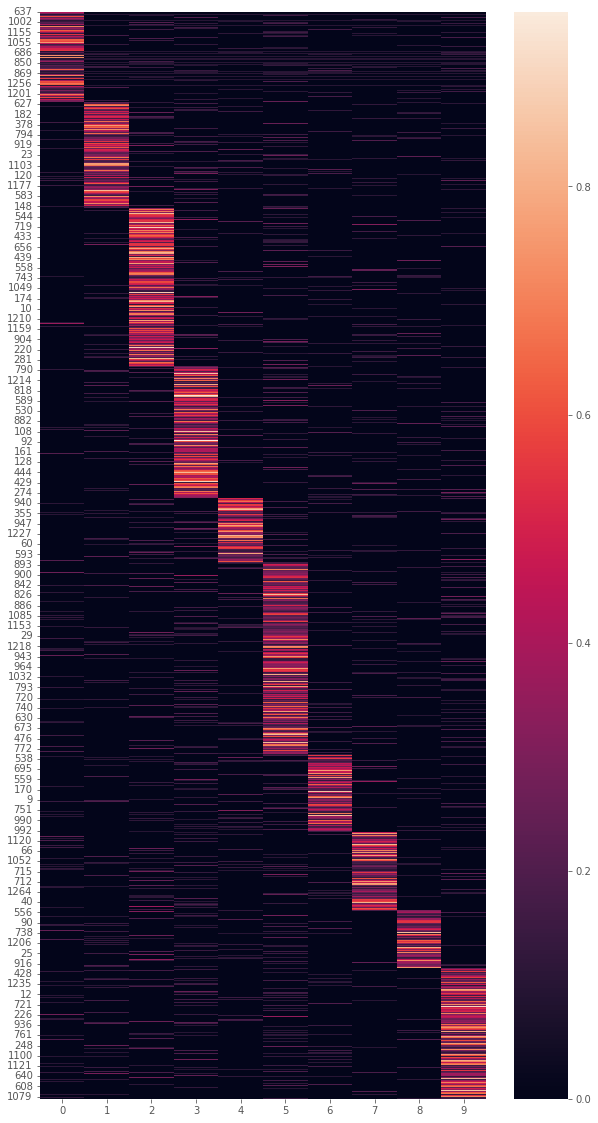

In [28]:
heatmap_df = topics_in_documents[range(num_topics)]

fig, ax = plt.subplots(1, 1, figsize=(10, 20))
sns.heatmap(heatmap_df.loc[heatmap_df.idxmax(axis=1).sort_values().index], ax=ax);

- Display **primary topic distribution** (i.e. the most relevant topic for each document) plot over years. We see generally that most of the topics remained relevant for the whole period of 4 years. Regarding the question of whether the topics changed over years, this question could effectively be answered if we modelled each year separately and compared topics across years - this excercise was quite time demanding so I just outlined the idea/direction I would pursue. However, given the low number of observations and uncertainty in establishing the right labels for each identified topic, it would be relatively imprecise comparison or would require deeper analysis of underlying data.

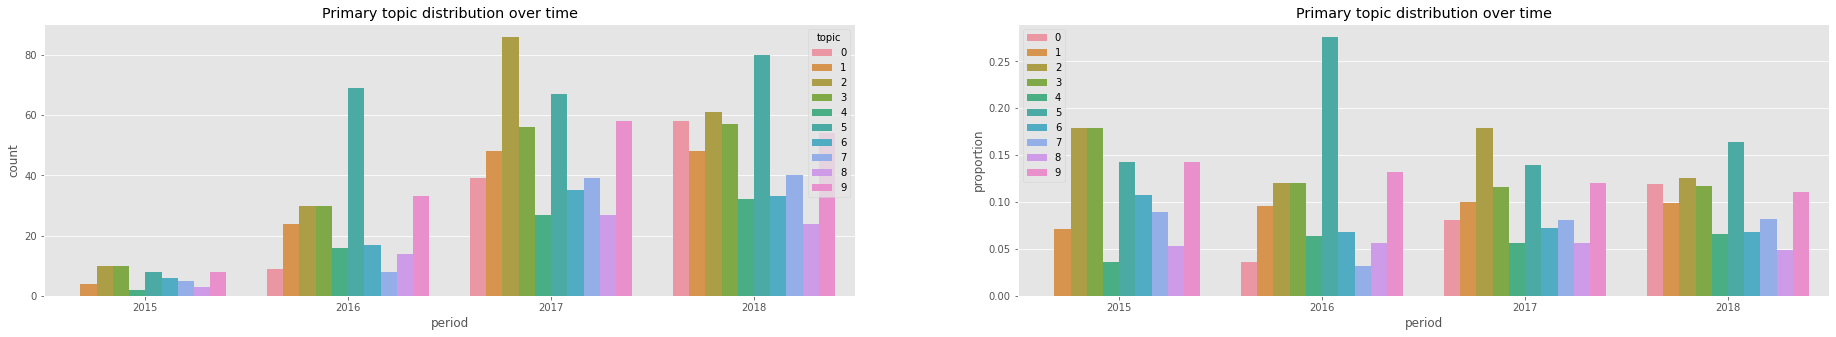

In [29]:
primary_topics = pd.DataFrame(data={"topic": topics_in_documents[range(num_topics)].idxmax(axis=1), "period": topics_in_documents.period})
grouped = primary_topics.groupby(["period", "topic"]).agg(count=("topic", "count")).reset_index()
grouped["proportion"] = grouped["count"]/grouped.groupby("period")["count"].transform("sum")

fig, axs = plt.subplots(1, 2, figsize=(32, 5))
axs[0] = sns.countplot(x="period", hue="topic", data=primary_topics, ax=axs[0])
axs[0].set_title("Primary topic distribution over time");

axs[1] = sns.barplot(x="period", y="proportion", hue="topic", data=grouped, ax=axs[1])
axs[1].set_title("Primary topic distribution over time");
plt.legend(loc='upper left');